In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import find_peaks

In [2]:
gold_dataset_addr = "./data/Gold Price.csv"
gold_dataset = pd.read_csv(gold_dataset_addr)
gold_dataset.head(10)

,Date,Price,Open,High,Low,Volume,Chg%
0,2025-01-06,77149,77309,77542,76545,27160,0.44
1,2025-01-03,76813,77246,78600,76613,60,-0.05
2,2025-01-02,76849,76849,76849,76849,0,0.83
3,2025-01-01,76214,76232,76302,76053,60,-0.02
4,2024-12-31,76232,75680,76970,75572,1920,0.95
5,2024-12-30,75517,75443,76450,75336,10260,-0.35
6,2024-12-27,75783,76160,76445,75661,15260,-0.43
7,2024-12-26,76114,75868,76200,75760,9730,0.73
8,2024-12-24,75562,75625,75688,75424,10820,0.07
9,2024-12-23,75506,75680,75964,75352,14200,-0.37


In [3]:
gold_dataset.tail(3)

,Date,Price,Open,High,Low,Volume,Chg%
2845,2014-01-03,29727,30031,30125,29539,3050,-0.83
2846,2014-01-02,29975,29678,30050,29678,3140,1.47
2847,2014-01-01,29542,29435,29598,29340,2930,0.25


In [4]:
gold_dataset.info()
gold_dataset.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2848 non-null   object 
 1   Price   2848 non-null   int64  
 2   Open    2848 non-null   int64  
 3   High    2848 non-null   int64  
 4   Low     2848 non-null   int64  
 5   Volume  2848 non-null   int64  
 6   Chg%    2848 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 155.9+ KB


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')

### Data preparation steps

- Convert 'Date' to datetime
- Convert 'Price' from Indian Rupees to US Dollars
- Check null values

In [5]:
gold_dataset['Date'] = pd.to_datetime(gold_dataset['Date'])
gold_dataset.set_index('Date', inplace=True)

In [6]:
conversion_rate = 85.96
price_columns = ['Price', 'Open', 'High', 'Low']

for col in price_columns:
    gold_dataset[col] =round(gold_dataset[col].astype(float) / conversion_rate, 2)


In [7]:
gold_dataset.dtypes

Price     float64
Open      float64
High      float64
Low       float64
Volume      int64
Chg%      float64
dtype: object

In [8]:
gold_dataset.isnull().sum()

Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64

In [9]:
gold_dataset.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2025-01-06,897.50,899.36,902.07,890.47,27160,0.44
2025-01-03,893.59,898.63,914.38,891.26,60,-0.05
2025-01-02,894.01,894.01,894.01,894.01,0,0.83
2025-01-01,886.62,886.83,887.65,884.75,60,-0.02
2024-12-31,886.83,880.41,895.42,879.15,1920,0.95


### Exploratory Data Analysis on Price (EDA)

In [10]:
fig = go.Figure()

# Add the gold price trace
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Price'],
    name='Gold Price',
    mode='lines'
))

# Update layout
fig.update_layout(
    title='Gold Price Over Time',
    xaxis_title='Date',
    yaxis_title='Price',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

# Show the figure
fig.show()

De está gráfica podemos observar lo siguiente:
- La tendencia del precio es a la alza.
- Se notan algunos periodos en los que el precio parece subir muy rápidamente, lo que indica que hay volatilidad.
- No parece haber patrones claros de estacionalidad.
- No parece haber cambios en generales en la tendencia.

In [11]:
gold_dataset['SMA_14'] = gold_dataset['Price'].rolling(window=14).mean()

# Create plot
fig = go.Figure()

# Plot original gold price
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Price'],
    name='Gold Price',
    mode='lines',
    line=dict(color='gold')
))

# Plot EMA
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['SMA_14'],
    name='14-Day SMA',
    mode='lines',
    line=dict(color='darkgreen', width=2, dash='dot')
))

# Update layout
fig.update_layout(
    title='Gold Price with 14-Day Simple Moving Average',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

fig.show()

In [12]:
gold_dataset['EMA_14'] = gold_dataset['Price'].ewm(span=14, adjust=False).mean()

# Create plot
fig = go.Figure()

# Plot original gold price
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Price'],
    name='Gold Price',
    mode='lines',
    line=dict(color='gold')
))

# Plot EMA
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['EMA_14'],
    name='14-Day EMA',
    mode='lines',
    line=dict(color='darkgreen', width=2, dash='dot')
))

# Update layout
fig.update_layout(
    title='Gold Price with 14-Day Exponential Moving Average',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

fig.show()


Tanto la media móvil simple (SMA) como la media móvil exponencial (EMA) nos permiten suavizar la serie de tiempo y observar mejor la tendencia del precio del oro. Cabe notar que la EMA da más peso a los precios recientes, lo que la hace más sensible a los cambios recientes en el precio.

Ahora analizaremos un poco más a fondo los mínimos locales en el precio. Para ello utilizamos la función `find_peaks` de `scipy.signal` para encontrar los mínimos locales. Luego verificamos si estos mínimos son "irreversibles", es decir, si todos los precios posteriores son mayores o iguales al mínimo encontrado.

In [13]:
# --- Prepare data --------------------------
gold = gold_dataset.copy()
gold = gold.sort_index().dropna(subset=['Price'])
prices = gold['Price'].values

# --- Local minima --------------------------
minima_indices, props = find_peaks(-prices, prominence=10)

# --- Irreversible minima by running future-minimum ---
running_future_min = np.minimum.accumulate(prices[::-1])[::-1]
irreversible_mask = (prices == running_future_min) & np.isin(np.arange(len(prices)), minima_indices)
irreversible_indices = np.where(irreversible_mask)[0]
irreversible_prices = gold.iloc[irreversible_indices]

print("Total local minima:", len(minima_indices))
print("Total irreversible minima:", len(irreversible_indices))

# --- Plot ------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(x=gold.index, y=prices, mode='lines', name='Price'))

fig.add_trace(go.Scatter(
    x=irreversible_prices.index,
    y=irreversible_prices['Price'],
    mode='markers', name='Irreversible minima',
    marker=dict(color='red', size=7, symbol='x')
))
fig.update_layout(
    title='Gold Price: Local vs. Irreversible Minima',
    xaxis_title='Date', yaxis_title='Price',
    template='plotly_white', height=600, width=1000
)
fig.show()


Total local minima: 83
Total irreversible minima: 30


In [14]:
# Calculate days between consecutive irreversible minima
time_gaps = (
    irreversible_prices.index.to_series().diff().dt.days.dropna()
)

# Convert to a DataFrame for clarity
time_gaps_df = pd.DataFrame({
    'Start': time_gaps.index[:-1],
    'End': time_gaps.index[1:],
    'Days Between': time_gaps.values[1:]
})

print("Time Gaps Between Irreversible Minima:")
print(time_gaps_df)

Time Gaps Between Irreversible Minima:
        Start        End  Days Between
0  2015-12-17 2016-12-21         370.0
1  2016-12-21 2017-07-07         198.0
2  2017-07-07 2017-12-12         158.0
3  2017-12-12 2018-08-16         247.0
4  2018-08-16 2018-11-30         106.0
5  2018-11-30 2019-05-02         153.0
6  2019-05-02 2019-05-21          19.0
7  2019-05-21 2019-07-01          41.0
8  2019-07-01 2019-09-30          91.0
9  2019-09-30 2019-12-12          73.0
10 2019-12-12 2020-01-14          33.0
11 2020-01-14 2020-03-16          62.0
12 2020-03-16 2021-03-29         378.0
13 2021-03-29 2021-09-29         184.0
14 2021-09-29 2021-11-03          35.0
15 2021-11-03 2021-12-02          29.0
16 2021-12-02 2022-01-10          39.0
17 2022-01-10 2022-01-28          18.0
18 2022-01-28 2022-09-26         241.0
19 2022-09-26 2022-11-03          38.0
20 2022-11-03 2023-03-08         125.0
21 2023-03-08 2023-10-05         211.0
22 2023-10-05 2023-11-10          36.0
23 2023-11-10 2023-12-12 

Ahora verificamos si hay alguna anomalía en el precio. Para hacerlo calculamos la media y la desviación estandard en 'Price'. Marcamos los puntos que están a más de tres desviaciones estándard de la media.

In [15]:
mean = gold_dataset['Price'].mean()
std = gold_dataset['Price'].std()

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 479.54614466292134, Standard Deviation: 167.2231304553272


In [16]:
anomalies = gold_dataset[(gold_dataset['Price'] > mean + 3*std) | (gold_dataset['Price'] < mean - 3*std)]

print(f"Number of anomalies in price detected: {len(anomalies)}")

Number of anomalies in price detected: 0


In [17]:
gold_dataset['Growth_Rate'] = gold_dataset['Price'].pct_change() * 100
gold_growth = gold_dataset.dropna(subset=['Growth_Rate'])

In [18]:
seasonal_decompose_result = seasonal_decompose(gold_dataset['Price'], model='additive', period=40)

<Figure size 20000x10000 with 0 Axes>

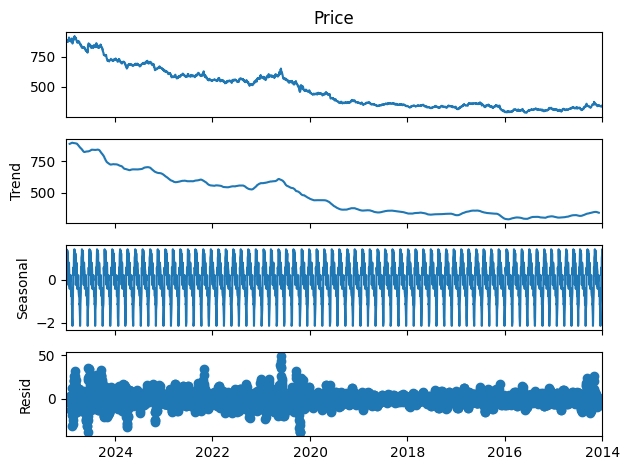

In [19]:

plt.figure(figsize=(200, 100))
seasonal_decompose_result.plot()

plt.tight_layout()
plt.show()


In [20]:

fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=("Original Series", "Trend", "Seasonality", "Residual")
)

# Add traces for each component
fig.add_trace(go.Scatter(x=gold_dataset.index, y=gold_dataset['Price'],
                         mode='lines', name='Original'), row=1, col=1)

fig.add_trace(go.Scatter(x=seasonal_decompose_result.trend.index, y=seasonal_decompose_result.trend,
                         mode='lines', name='Trend'), row=2, col=1)

fig.add_trace(go.Scatter(x=seasonal_decompose_result.seasonal.index, y=seasonal_decompose_result.seasonal,
                         mode='lines', name='Seasonality'), row=3, col=1)

fig.add_trace(go.Scatter(x=seasonal_decompose_result.resid.index, y=seasonal_decompose_result.resid,
                         mode='lines', name='Residuals'), row=4, col=1)


fig.update_layout(
    height=900,
    title_text='Interactive Seasonal Decomposition of Gold Price',
    showlegend=False
)

fig.show()

Comparación del modelo aditivo con el modelo multiplicativo:

In [21]:
series = gold_dataset['Price']

# Decomposition by additive and multiplicative models
decomp_add = seasonal_decompose(series, model='additive', period=40)
decomp_mul = seasonal_decompose(series, model='multiplicative', period=40)


In [22]:
fig = make_subplots(
    rows=4, cols=2,
    shared_xaxes=True,
    column_widths=[0.5, 0.5],
    horizontal_spacing=0.07,
    vertical_spacing=0.03,
    subplot_titles=(
        "Original", "Original",
        "Trend (Add)", "Trend (Mult)",
        "Seasonality (Add)", "Seasonality (Mult)",
        "Residuals (Add)", "Residuals (Mult)"
    )
)

# Row 1: Original Series
fig.add_trace(go.Scatter(x=series.index, y=series, name='Original', mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=series.index, y=series, name='Original', mode='lines'), row=1, col=2)

# Row 2: Trends
fig.add_trace(go.Scatter(x=decomp_add.trend.index, y=decomp_add.trend, name='Trend Add', mode='lines'), row=2, col=1)
fig.add_trace(go.Scatter(x=decomp_mul.trend.index, y=decomp_mul.trend, name='Trend Mult', mode='lines'), row=2, col=2)

# Row 3: Seasonality
fig.add_trace(go.Scatter(x=decomp_add.seasonal.index, y=decomp_add.seasonal, name='Seasonal Add', mode='lines'), row=3, col=1)
fig.add_trace(go.Scatter(x=decomp_mul.seasonal.index, y=decomp_mul.seasonal, name='Seasonal Mult', mode='lines'), row=3, col=2)

# Row 4: Residuals
fig.add_trace(go.Scatter(x=decomp_add.resid.index, y=decomp_add.resid, name='Residuals Add', mode='lines'), row=4, col=1)
fig.add_trace(go.Scatter(x=decomp_mul.resid.index, y=decomp_mul.resid, name='Residuals Mult', mode='lines'), row=4, col=2)

# Layout and style
fig.update_layout(
    height=1000,
    width=1200,
    title_text='Additive vs. Multiplicative Decomposition of Gold Price (30-day Period)',
    showlegend=False
)

fig.show()


Usamos la prueba ADF (Augmented Dickey-Fuller) para verificar la estacionariedad

In [23]:
result = adfuller(gold_dataset['Price'].dropna())

In [24]:
print("Estadístico ADF:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Valor crítico {key}: {value:.4f}')

Estadístico ADF: -2.6860179455329924
p-value: 0.07648918373565519
Valor crítico 1%: -3.4327
Valor crítico 5%: -2.8626
Valor crítico 10%: -2.5673


De acuerdo con la prueba ADF, el p-valor es mayor a 0.05, lo que indica que no podemos rechazar la hipótesis nula de que la serie es no estacionaria. También los valores críticos en 1% y 5% son mayores que el estadístico de prueba. Esto nos indica que debemos tratar la serie como no estacionaria.

Aplicaremos una diferenciación de primer orden para hacer la serie estacionaria. Esto implica restar el valor actual del valor anterior.

In [25]:
gold_dataset['Price_diff'] = gold_dataset['Price'].diff()
price_diff = gold_dataset['Price_diff'].dropna()
print(price_diff.head())

Date
2025-01-03   -3.91
2025-01-02    0.42
2025-01-01   -7.39
2024-12-31    0.21
2024-12-30   -8.32
Name: Price_diff, dtype: float64


In [26]:
adf_result_diff = adfuller(price_diff)

print("ADF Statistic:", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f'Critical Value ({key}): {value:.4f}')

ADF Statistic: -35.973185709783344
p-value: 0.0
Critical Value (1%): -3.4327
Critical Value (5%): -2.8626
Critical Value (10%): -2.5673


Luego de aplicar la diferenciación de primer orden, verificamos nuevamente la estacionariedad con la prueba ADF. El p-valor es menor a 0.05, lo que indica que podemos rechazar la hipótesis nula de que la serie es no estacionaria. También los valores críticos en 1% y 5% son menores que el estadístico de prueba. Esto nos indica que la serie es estacionaria.

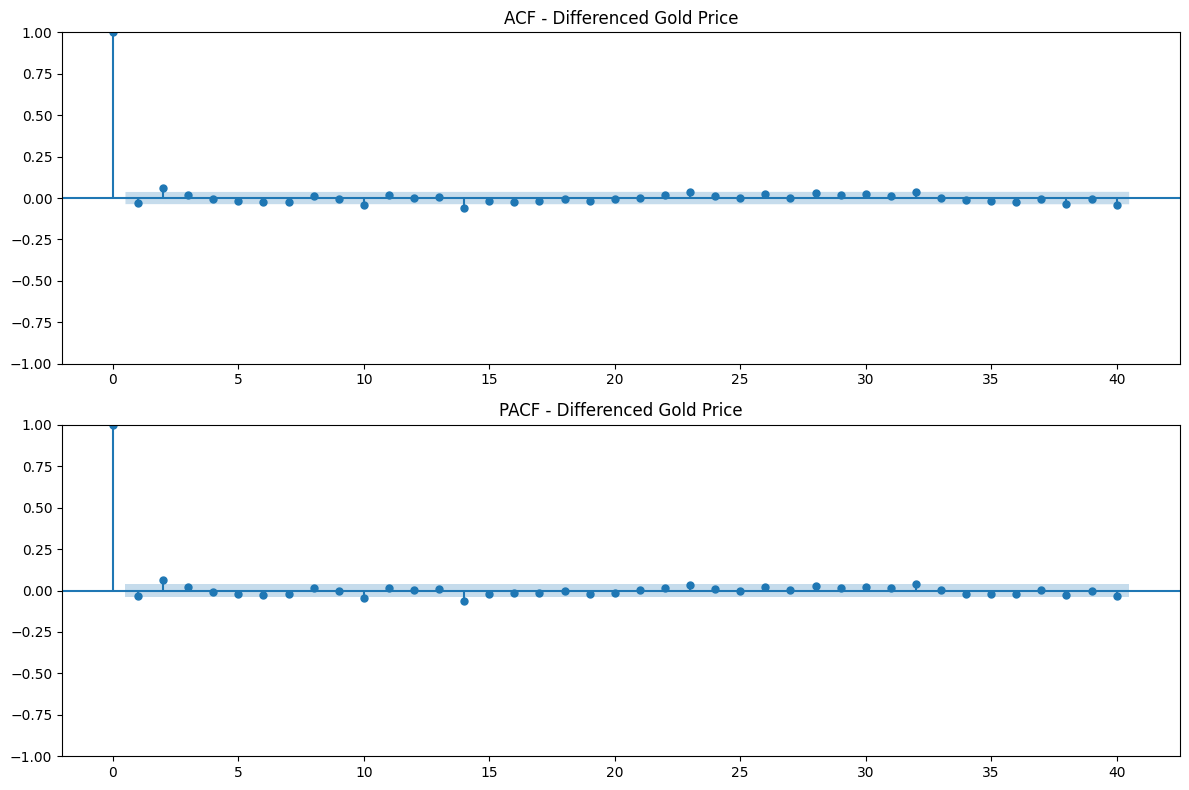

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot (for MA terms)
plot_acf(price_diff, ax=axs[0], lags=40)
axs[0].set_title('ACF - Differenced Gold Price')

# PACF plot (for AR terms)
plot_pacf(price_diff, ax=axs[1], lags=40, method='ywm')
axs[1].set_title('PACF - Differenced Gold Price')

plt.tight_layout()
plt.show()

De acuerdo a nuestro gráfico de ACF y PACF, podemos observar que luego del lag 0, los valores de ACF y PACF caen por debajo de 0.25, lo que sugiere que no hay correlación significativa en los lags posteriores. Esto quiere decir que en la serie solo tenemos ruido y no hay patrones significativos que podamos modelar de momento. Intentaremos con una estacionalidad diferente.

In [28]:
price_series_diff = gold_dataset['Price_diff'].dropna().values

# Apply Fourier-based periodogram
frequencies, power = periodogram(price_series_diff)

# Avoid division by zero for frequency=0
frequencies = frequencies[1:]
power = power[1:]


In [29]:
periods = 1 / frequencies

# Create Plotly interactive figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=periods,
    y=power,
    mode='lines',
    name='Spectral Power',
    line=dict(color='royalblue')
))

# Update layout
fig.update_layout(
    title='Periodogram (Fourier Analysis of Gold Prices)',
    xaxis_title='Period (days)',
    yaxis_title='Spectral Power',
    xaxis=dict(type='linear'),
    template='plotly_white',
    hovermode='x unified',
    width=900,
    height=500
)

fig.show()

De este gráfico podemos observar que la serie tiene una estacionalidad que el pico más alto ocurre en 24, lo que sugiere una estacionalidad de 24 días. También podemos notar que hay otros picos menores en 10, 6 y 15.
Haremos una nueva descomposición de la serie con una estacionalidad de 24 días.

In [30]:
# STL decomposition
price_series = gold_dataset['Price'].dropna()
stl = STL(price_series, period=24)
res = stl.fit()

# Extract components
trend = res.trend
seasonal = res.seasonal
resid = res.resid


In [31]:
fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=("Original Series", "Trend", "Seasonality", "Residual")
)

# Add each component as a trace
fig.add_trace(go.Scatter(x=price_series.index, y=price_series,
                         mode='lines', name='Original', line=dict(color='black')), row=1, col=1)

fig.add_trace(go.Scatter(x=trend.index, y=trend,
                         mode='lines', name='Trend', line=dict(color='blue')), row=2, col=1)

fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal,
                         mode='lines', name='Seasonality', line=dict(color='orange')), row=3, col=1)

fig.add_trace(go.Scatter(x=resid.index, y=resid,
                         mode='lines', name='Residuals', line=dict(color='red')), row=4, col=1)

# Update layout
fig.update_layout(
    height=900,
    title_text='Interactive STL Decomposition of Gold Price (Period = 24)',
    showlegend=False,
    template='plotly_white'
)

fig.show()

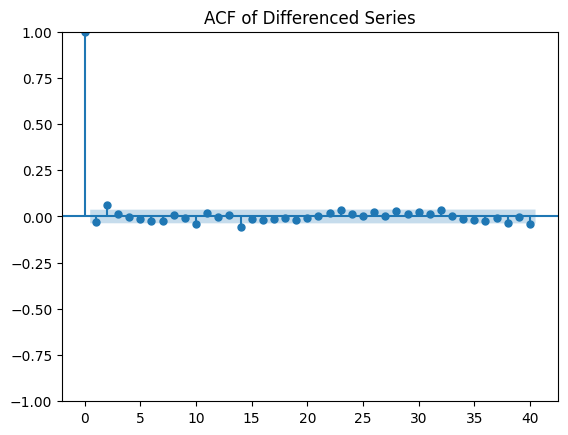

In [32]:
differenced = price_series.diff().dropna()

plot_acf(differenced, lags=40)
plt.title('ACF of Differenced Series')
plt.show()

Division de los datos en entrenamiento y test:

In [33]:
gold_dataset.index = pd.to_datetime(gold_dataset.index)
gold_dataset = gold_dataset.sort_index()


In [34]:
train = gold_dataset[:'2023-12-31']
test = gold_dataset['2024-01-01':]

In [35]:
model = ARIMA(train['Price'], order=(0, 1, 0))
model_fit = model.fit()

/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [36]:
n_steps = len(test)
forecast = model_fit.forecast(steps=n_steps)

/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [37]:
mae = mean_absolute_error(test['Price'], forecast)
mse = mean_squared_error(test['Price'], forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 95.17
RMSE: 108.69


In [38]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, y=forecast, mode='lines', name='Forecast'))

fig.update_layout(
    title="Gold Price Forecast: ARIMA(0,1,0)",
    xaxis_title="Date",
    yaxis_title="Price (INR)",
    template='plotly_white'
)

fig.show()

In [39]:
next_5_forecast = model_fit.forecast(steps=5)

print("Next 5 days forecast:")
print(next_5_forecast)

Next 5 days forecast:
2587    732.36
2588    732.36
2589    732.36
2590    732.36
2591    732.36
Name: predicted_mean, dtype: float64


/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/tux/time-series-analysis-gold/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

